#**Capstone project: Can ML Outperform Market-Neutral Trading in Structural Breaks?**

**Note:**

It's a good practise to "restart the session", whenever changes are made to the github repository


##**Step 1:** GitHub setup

1) Clone/Update the projects github repository

In [1]:
# Use for the first time to clone the github repo or when the repo is updated
%rm -rf /content/MarketNeutral_Trading_multiple_pairs/
%cd /content
!git clone https://github.com/WQU-Capstone-11205/MarketNeutral_Trading_multiple_pairs.git
%cd /content/MarketNeutral_Trading_multiple_pairs/

/content
Cloning into 'MarketNeutral_Trading_multiple_pairs'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 145 (delta 61), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (145/145), 1.18 MiB | 1.65 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/MarketNeutral_Trading_multiple_pairs


2) Add the project's github repository's path to the system path

In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/content/MarketNeutral_Trading_multiple_pairs')

3) Install projects required packages

In [3]:
!pip install -r requirements.txt

##**Step 2:** Data loading

- Load data and convert to distance spread

In [4]:
from util.ff_benchmark import get_ff_benchmark_returns
from data_loading.fetch_data import fetch_from_yfinance
from data_loading.PairsSpread import SP500PairSpread

start_date = '2005-01-01' #'2019-01-01' # '2005-01-01'
end_date = '2025-01-01' # '2024-01-01' # '2025-01-01'
in_sample_cutoff_date = '2022-01-01' # '2017-01-01' # After this date the cointegration fails

# Fetch a benchmark for alpha/beta calculation (e.g., SPY)
benchmark_data = fetch_from_yfinance(['SPY'], start_date, end_date)
benchmark_returns = benchmark_data.pct_change().dropna()
train_spy_returns = benchmark_returns.loc[:in_sample_cutoff_date]
test_spy_returns = benchmark_returns.loc[in_sample_cutoff_date:]
ff_benchmark_returns = get_ff_benchmark_returns(in_sample_cutoff_date, end_date)

selector = SP500PairSpread(
    selection_start=start_date,
    selection_end=end_date,
    method="distance",
    pairs_per_sector=4
)

spread = selector.distance_spread()

# price data used to compute cointegration
tickers = sorted(set(t for pair in spread.columns for t in pair.split("-")))
price_df = fetch_from_yfinance(tickers, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


Fetching SP500 pairs from Wikipedia...
Calculating spread...


[*********************100%***********************]  66 of 66 completed
[*********************100%***********************]  66 of 66 completed


**Report on pair characteristics:**

In [5]:
from metrics.ReportPairCharacteristics import ReportPairCharacteristics

char_reporter = ReportPairCharacteristics(spread, price_df)
pair_chars = char_reporter.compute_characteristics()
dispersion = char_reporter.dispersion_summary()

print(pair_chars)
print("\nDispersion summary:")
print(dispersion)

train_spread = spread.loc[:in_sample_cutoff_date]
test_spread = spread.loc[in_sample_cutoff_date:]

spread_returns = spread.pct_change().dropna()
train_spread_returns = spread_returns.loc[:in_sample_cutoff_date]
test_spread_returns = spread_returns.loc[in_sample_cutoff_date:]

            coint_pvalue  norm_price_dist  spread_vol    half_life
pair                                                              
AIG-C           0.000003         7.149359   91.889388   375.127716
HBAN-KEY        0.502878         8.772259    1.438691   262.367445
KEY-RF          0.395494         9.124750    2.178080   334.424710
HBAN-RF         0.229079         9.582847    1.538161   238.696899
GOOG-GOOGL      0.000127        12.681013    0.724869    47.285069
OMC-VZ          0.509565        36.708879   11.369856   279.298810
T-VZ            0.528409        46.656742    1.578215   283.884511
CMCSA-DIS       0.067984        52.390916    4.004945   143.451278
EXC-FE          0.092862        18.922602    3.718303   235.086290
AEP-DUK         0.408990        22.499550    4.819236   220.078423
ED-SO           0.866676        26.079000    6.708050  1159.288663
PEG-SO          0.358249        27.669410    4.044912   149.008246
DD-IP           0.076666        19.238987    3.650723   148.22

<Figure size 600x300 with 0 Axes>

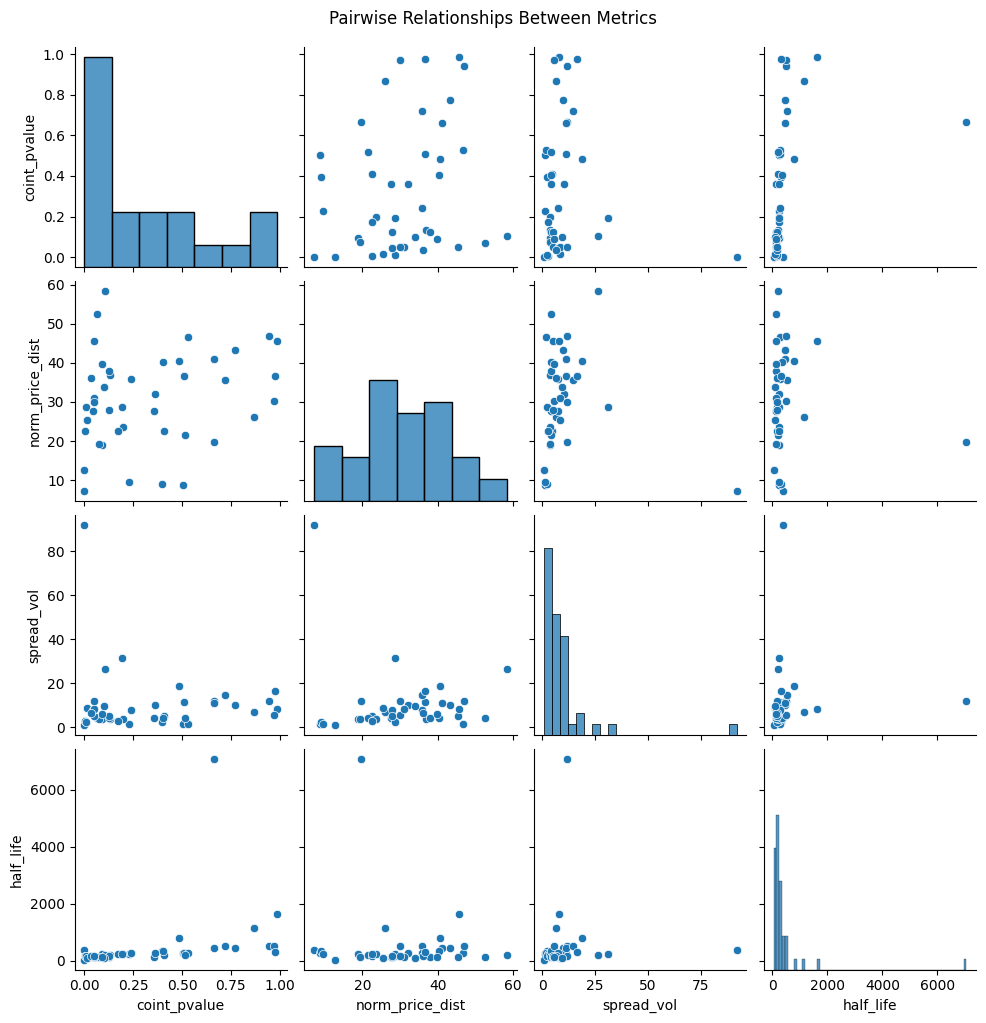

In [6]:
from plots.pairwiseplot import show_pairwise_relations
show_pairwise_relations(pair_chars)


**Inference:** The evaluated pairs span heterogeneous regimes in terms of cointegration, short-term similarity, volatility, and mean-reversion speed, providing a robust cross-section for performance analysis.

1) Cointegration p-value:
* Range: 0.000003 → 0.986
* Median: 0.197 → about half the pairs have strong cointegration (p < 0.2)
* 10th percentile: 0.0187 → some pairs are extremely stable
* 90th percentile: 0.847 → some pairs have weak or almost no cointegration

  Interpretation: The cross-section includes both stable and unstable cointegration pairs that shows good diversity along long-run equilibrium dimension.

2) Normalized price distance:
* Range: 7.15 → 58.33
* Median: 30.10
* 10th percentile: 13.93 → some pairs track very closely
* 90th percentile: 45.64 → some pairs are far apart in normalized price

  Interpretation: It shows short-term similarity differences, some pairs move very similarly, others are quite far apart. This combined with cointegration, ensures pairs have a mix of tight and loose spreads. It shows good diversity along short-term distance / co-movement.

3) Spread volatility:
* Range: 0.72 → 91.88
* Median: 5.76
* 10th percentile: 2.23 → very low-vol pairs
* 90th percentile: 15.98 → high-vol pairs

  Interpretation: The cross-section contains low-risk and high-risk pairs. Volatility heterogeneity complements cointegration heterogeneity. High-vol pairs may need wider z-score thresholds and low-vol pairs are slow-moving. It demonstrates good diversity along risk/volatility dimension.

4) Half-life:
* Range: 47 → 7055 days
* Median: 238 → typical mean-reversion speed ~ 1 year
* 10th percentile: 124 → faster mean reversion
* 90th percentile: 529 → slow mean reversion
* Max: 7055 → essentially non-mean-reverting

  Interpretation: The cross-section contains fast, moderate, and extremely slow mean-reverting pairs. Half-life and cointegration together show structural stability and trading horizon diversity. It shows strong diversity along speed of reversion/mean-reversion timescale.

5) Overall dispersion: All four metrics show wide spread across the cross-section. There are outliers, but that's fine it shows the strategy is tested across extreme scenarios. The pairs span a broad range of long-run stability, short-run co-movement, volatility, and mean-reversion speed.

**Report distributional results:**

In [7]:
from metrics.ReportDistributionalResults import ReportDistributionalResults

# initialize reporter
reporter = ReportDistributionalResults(test_spread, train_spread.mean(), train_spread.std())
# compute statistics
stats = reporter.distributional_stats()
# display results
for k, v in stats.items():
    print(f"{k:25s}: {v: .4f}")

median_performance       :  8.3690
p25_performance          :  0.6725
p75_performance          :  24.7698
interquartile_range      :  24.0973
worst_decile_drawdown    :  51.7212


**Conclusion:** While the median pair shows modest positive performance, there is substantial heterogeneity. The top-performing pairs outperform the median by approximately three times, and the worst-decile pairs experience large drawdowns. This underscores the importance of cross-sectional pair selection and risk management.

- Median Performance: The typical pair generates ~8.37 units of PnL (or return) in the test window. Median is robust to outliers, where most pairs are profitable, though not huge.
- 25th percentile: The lower quartile pair makes only ~0.67 units, which are very low or near break-even. This indicates that some pairs perform poorly or marginally.
- 75th percentile: The upper quartile pair is doing very well around 24.77 units. This shows some pairs are much more profitable than the median.
- Interquartile range: It measures dispersion of performance.A wide IQR indicates large cross-sectional differences, which says some pairs are much stronger than others.
- Worst Decile Drawdown: The 10% worst-performing pairs experience a drawdown of ~51.7 units. This indicates significant downside risk for some pairs. It highlights the importance of pair selection or risk control.

Overall Interpretation:
- Median positive: most pairs generate profits
- Wide IQR: high dispersion across pairs; some pairs are much stronger than others.
- Significant worst-decile drawdown: risk is concentrated in poorly performing pairs.

In [8]:
spread.describe()

,AIG-C,HBAN-KEY,KEY-RF,HBAN-RF,GOOG-GOOGL,OMC-VZ,T-VZ,CMCSA-DIS,EXC-FE,AEP-DUK,...,RSG-WM,EMR-EXPD,HAL-SLB,APA-DVN,BKR-DVN,EQT-HAL,MDT-PFE,DGX-JNJ,DGX-PFE,BMY-CVS
count,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03,...,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03,5.033000e+03
mean,-1.445650e-14,-9.035314e-17,-1.264944e-15,-9.035314e-17,-7.228251e-16,5.150129e-15,6.776485e-17,4.517657e-16,-2.891300e-15,-5.421188e-16,...,1.716710e-15,-6.505426e-15,-1.807063e-16,4.336951e-15,3.252713e-15,-3.614126e-15,3.885185e-15,2.891300e-15,8.131783e-15,1.445650e-15
std,9.188939e+01,1.438691e+00,2.178080e+00,1.538161e+00,7.248691e-01,1.136986e+01,1.578215e+00,4.004945e+00,3.718303e+00,4.819236e+00,...,5.482790e+00,8.216534e+00,4.908701e+00,1.449405e+01,7.532000e+00,6.381385e+00,1.165444e+01,9.579278e+00,1.635803e+01,5.764279e+00
min,-2.710780e+02,-5.222307e+00,-8.343617e+00,-4.796865e+00,-1.672610e+00,-3.706266e+01,-4.623838e+00,-1.061465e+01,-8.777928e+00,-9.771527e+00,...,-1.160533e+01,-2.872066e+01,-1.581937e+01,-4.477946e+01,-2.479293e+01,-1.743292e+01,-5.791080e+01,-3.252680e+01,-3.859657e+01,-1.349901e+01
25%,-4.439198e+01,-3.956383e-01,-4.033159e-01,-1.273038e+00,-1.798511e-01,-5.904592e+00,-6.510340e-01,-1.937459e+00,-2.456895e+00,-3.460975e+00,...,-2.464393e+00,-3.915684e+00,-4.035879e+00,-4.631282e+00,-5.339138e+00,-4.225253e+00,-4.911679e+00,-7.399226e+00,-1.157820e+01,-3.367503e+00
50%,-3.208874e+01,1.038107e-01,5.103078e-01,4.590817e-01,-5.929639e-02,5.677955e-02,2.373514e-01,-5.621218e-01,1.411486e-01,-4.635727e-01,...,-3.670824e-01,2.409933e-01,7.182398e-01,1.572654e+00,9.081106e-01,-1.167926e-01,1.616416e+00,2.189367e+00,2.774930e-01,-1.202449e+00
75%,-2.012306e+01,6.174787e-01,1.362015e+00,1.177445e+00,-1.988839e-02,4.741813e+00,8.794574e-01,7.937696e-01,1.565470e+00,2.161584e+00,...,1.007665e+00,4.257882e+00,3.772873e+00,1.041647e+01,5.767988e+00,4.214926e+00,5.877502e+00,6.780468e+00,7.249658e+00,3.105767e+00
max,3.624972e+02,3.851761e+00,2.987146e+00,2.635330e+00,5.595635e+00,4.217850e+01,5.357685e+00,1.759634e+01,1.211168e+01,1.785148e+01,...,2.894277e+01,2.685790e+01,1.360507e+01,2.733736e+01,1.774083e+01,2.213525e+01,2.835489e+01,3.227876e+01,7.544340e+01,2.456487e+01


##**Final Tuning/Training:**

In [9]:
from train.train_loop_rl import train_loop_rl

bocpd_params2 = {"hazard": 20, "mu": 0, "kappa": 0.3, "alpha": 1.0, "beta": 0.8}
vae_params2 = {'input_dim': 2, 'latent_dim': 12, 'hidden_dim': 256, 'lr': 0.001, 'vae_seq_len': 1, 'kl_wt': 0.01}
rl_params2 = {'state_dim': 12, 'hidden_dim': 64, 'lr': 1e-03, 'gamma': 0.99, 'cp_weight': 0.0, 'var_penalty': 0.01, 'var_window': 20, 'dd_penalty': 0.0, 'dd_threshold': 0.2, 'entropy_coef': 0.01, 'tau': 0.005}#, 'actor_l2': 1e-3}
joint_params2 = {'state_window': 25, 'base_action_sigma': 0.0, 'wt_multplier': 1.5, 'buffer_size_updates': 128, 'sample_batch_size': 16, 'transaction_cost': 0.001, 'tc_scale': 0.3, 'exploration_alpha': 0.8, 'update_every': 25}#50}


train_loop_rl(
    spreads=train_spread,
    bocpd_params=bocpd_params2,
    vae_params=vae_params2,
    rl_params=rl_params2,
    joint_params=joint_params2,
    num_epochs=20
)

Epoch 000 | recon loss = 0.1062 | kl loss = 0.0237 | policy loss = 0.0483 | Cumulative PnL = 716.8517
Saved all models + optimizers
Saved best models at epoch 000 (Sharpe=0.100)
Epoch 001 | recon loss = 0.0005 | kl loss = 0.0141 | policy loss = -0.1217 | Cumulative PnL = 1666.8966
Saved all models + optimizers
Saved best models at epoch 001 (Sharpe=1.064)
Epoch 002 | recon loss = 0.0008 | kl loss = 0.0137 | policy loss = -0.1079 | Cumulative PnL = 1016.8159
No improvement. Early stopping patience counter = 1/5
Epoch 003 | recon loss = 0.0008 | kl loss = 0.0135 | policy loss = -0.0223 | Cumulative PnL = 766.3922
No improvement. Early stopping patience counter = 2/5
Epoch 004 | recon loss = 0.0008 | kl loss = 0.0134 | policy loss = -0.0233 | Cumulative PnL = 1064.9816
No improvement. Early stopping patience counter = 3/5
Epoch 005 | recon loss = 0.0008 | kl loss = 0.0134 | policy loss = -0.1726 | Cumulative PnL = 593.5636
No improvement. Early stopping patience counter = 4/5
Epoch 006 | 

In [10]:
from backtest.evaluate_loop_rl import evaluate_loop_rl

test_metrics, results = evaluate_loop_rl(
                    spreads=test_spread,
                    bocpd_params=bocpd_params2,
                    vae_params=vae_params2,
                    rl_params=rl_params2,
                    joint_params=joint_params2,
                    use_trained_rms=True
                )

Loaded models/opts
Evaluation loop: Sharpe Ratio = 1.2466522036149905


##**Step 6:** Test metrics BOCPD+VAE+RL pipeline:

In [11]:
import numpy as np
from metrics.stats import sharpe_ratio, compute_max_drawdown, sortino_ratio, annual_volatility, alpha_beta

print("Test metrics for BOCPD+VAE+RL model:")
cum_pnl = np.cumsum(test_metrics['portfolio_pnl'])
print(f"Cummulative profit and loss                       : {cum_pnl[-1]:.6f}")
print(f"Sharpe Ratio                                      : {sharpe_ratio(test_metrics['portfolio_pnl']):.6f}")
print(f"Sortino ratio                                     : {sortino_ratio(test_metrics['portfolio_pnl']):.6f}")
print(f"Max drawdown                                      : {compute_max_drawdown(np.cumsum(test_metrics['portfolio_pnl'])):.6f}")
print(f"Annual Volatility                                 : {annual_volatility(test_metrics['portfolio_pnl']):.6f}")
alpha_ff, beta_ff = alpha_beta(test_metrics['portfolio_pnl'], ff_benchmark_returns)
print(f"Factor-adjusted Alpha-Beta                        : alpha = {alpha_ff:.6f} , beta = {beta_ff:.6f}")
alpha_spy, beta_spy = alpha_beta(test_metrics['portfolio_pnl'], test_spy_returns)
print(f"CAPM Alpha-Beta versus SPY                        : alpha = {alpha_spy:.6f} , beta = {beta_spy:.6f}")


Test metrics for BOCPD+VAE+RL model:
Cummulative profit and loss                       : 440.561148
Sharpe Ratio                                      : 1.246652
Sortino ratio                                     : 1.777590
Max drawdown                                      : 3.765783
Annual Volatility                                 : 118.425052
Factor-adjusted Alpha-Beta                        : alpha = 149.649770 , beta = -33.590883
CAPM Alpha-Beta versus SPY                        : alpha = 151.189894 , beta = -34.946925
